# Run Objective:

### Run0153


I was thinking that the c_3 module introduced in "2018-10-28 (New Idea)" managed to capture the polynomial behaviour quite well even though the thresholding died. That's what inspired me to try out these network architecture:
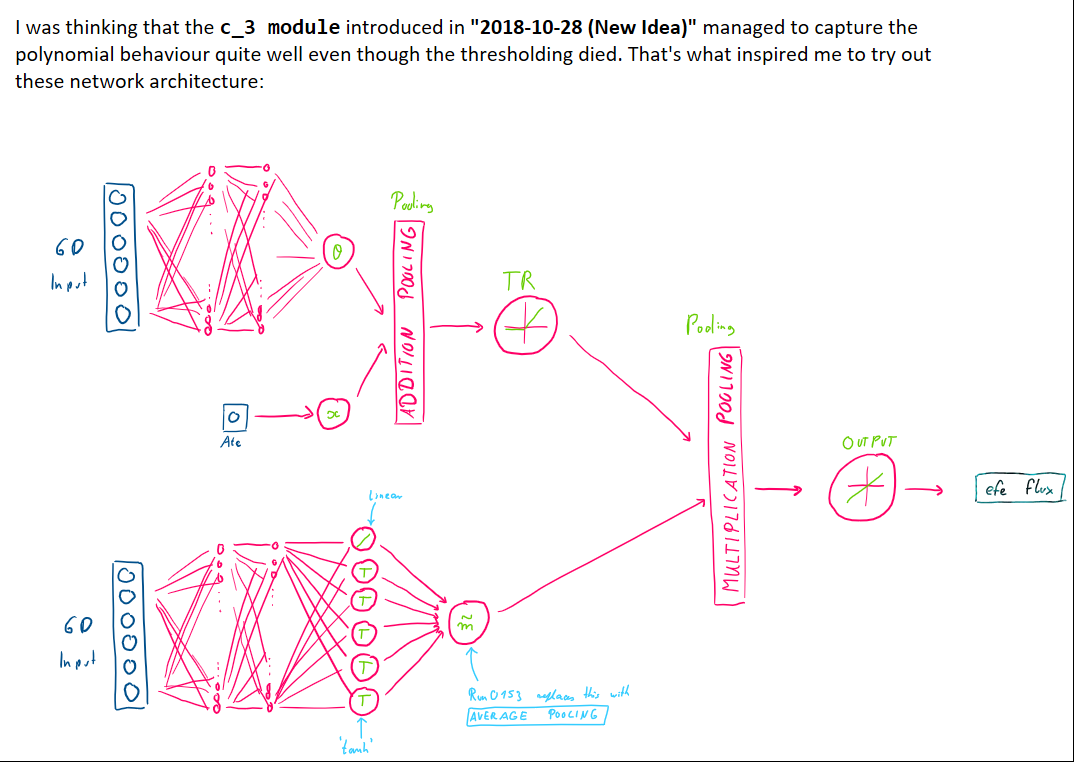

-  Based on `Run0145`.

In [ ]:
# DO NOT RUN THIS PART

In [ ]:
import os
import sys
import time

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])
print(file_name)

if file_name == "ipykernel_launcher":
    print("This is the Jupyter version.")
    print("Now MANUALLY run the next two cells!")
    print("STOP! This should not be in your code!!")
    exit(0)
    time.sleep(10)
    print("Testing if script has really stopped.")
else:
    print("This is the Atom version")

In [1]:
# RUN ONLY IN JUPYTER!!
# Start here (manual)

In [2]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"');

<IPython.core.display.Javascript object>

In [3]:
print(file_name)

2018-11-11_Run0153.ipynb


In [4]:
file_name = file_name[:-6]
print(file_name)

is_Jupyter = True
print(is_Jupyter)

2018-11-11_Run0153
True


In [5]:
# Same code for both ATOM & JUPYTER from now (Run all cells below now)

In [6]:
'''
Late Fusion Module (test) - Functional API
'''

# Multiple Inputs
import keras
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal, glorot_normal, Constant
from keras.utils import plot_model
from keras.models import Model
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers import Dense
from keras.layers import MaxoutDense
from keras.layers.merge import concatenate
from keras import regularizers
from keras import backend as K
#from keras.backend import switch
import pandas
import numpy
import sys
import os
from copy import deepcopy
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers.advanced_activations import ThresholdedReLU

#keras.backend.clear_session()
K.clear_session()

Using TensorFlow backend.


In [7]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

In [8]:
# Modify for ATOM use

In [9]:
if is_Jupyter == True:
    pass
else:
    # Gets the current file name. Useful for procedurally generating output/log files.
    file_name =  os.path.basename(sys.argv[0][:-3])

In [10]:
# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

In [11]:
# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("training_gen3_7D_nions0_flat_filter8.h5")
target_df = store['/output/efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']

# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for later use
joined_dataFrame_original = deepcopy(joined_dataFrame)


# *************************************************************************** #
# Normalize data by standard deviation and mean-centering the data
# Standard configuration
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean()) / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['q'] = (joined_dataFrame['q'] - joined_dataFrame['q'].mean()) / joined_dataFrame['q'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Make a copy of shuffled_joined_dataFrame for later use
shuffled_joined_dataFrame_base = deepcopy(shuffled_joined_dataFrame)



# *************************************************************************** #
# Creates a pandas dataframe for the inputs (7D)
shuffled_clean_input_df_7D = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df_7D.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df_7D.iloc[int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9)):]
# *************************************************************************** #


# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()


In [12]:
shuffled_clean_input_df_7D.describe(include='all')

,Ati,Ate,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,-1.411493e-16,2.631393e-16,2.266966e-16,8.738537e-17,-1.724392e-17,-4.430517e-19,5.178112e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.639065e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-7.898708e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,-9.507533e-02,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,5.997202e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,2.684107e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [13]:
# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_1 = shuffled_clean_input_df_7D.drop('Ate', axis=1)

In [14]:
shuffled_clean_input_df_1.describe(include='all')

,Ati,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,-1.411493e-16,2.266966e-16,8.738537e-17,-1.724392e-17,-4.430517e-19,5.178112e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [15]:
print(shuffled_clean_input_df_1.shape)

(6479137, 6)


In [16]:
shuffled_clean_input_df_2 = shuffled_clean_input_df_7D.drop('Ati', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('An', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('q', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('smag', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('x', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('Ti_Te', axis=1)

In [17]:
shuffled_clean_input_df_2.describe(include='all')

,Ate
count,6.479137e+06
mean,2.631393e-16
std,1.000000e+00
min,-1.639065e+00
25%,-7.898708e-01
50%,-9.507533e-02
75%,5.997202e-01
max,2.684107e+00


In [18]:
print(shuffled_clean_input_df_2.shape)

(6479137, 1)


In [19]:
# *************************************************************************** #
# Branch 1

# Creates training dataset (90% of total data) for inputs
x_train_1 = shuffled_clean_input_df_1.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_1 = shuffled_clean_input_df_1.iloc[int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9)):]
# *************************************************************************** #

In [20]:
# *************************************************************************** #
# Branch 2

# Creates training dataset (90% of total data) for inputs
x_train_2 = shuffled_clean_input_df_2.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_2 = shuffled_clean_input_df_2.iloc[int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9)):]
# *************************************************************************** #

In [21]:
# branch1
visible_branch1 = Input(shape=(6, ), name="6D_INPUTS")
hidden1_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch1")(visible_branch1)
hidden2_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch1")(hidden1_branch1)
theta_branch1 = Dense(1,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="theta_branch1")(hidden2_branch1)
theta_branch1_feeder = Dense(1,
        activation='linear',
        kernel_initializer=Constant(value=-1),
        bias_initializer='Zeros',
        trainable=False,
        name="theta_branch1_feeder")(theta_branch1)

# branch2 (Ate input)
visible_branch2 = Input(shape=(1, ), name="Ate_INPUT")
visible_branch2_feeder = Dense(1,
                activation='linear',
                name="visible_branch2_feeder")(visible_branch2)

# addition_pooling (effectively subtraction though...)
addition_pooling = keras.layers.Add(name="Addition_Pooling")([theta_branch1_feeder, visible_branch2_feeder])

TR = Dense(1, activation='relu',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=False,
           name="TR")(addition_pooling)



'''
# branch 3 (for c_3)
hidden1_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch3")(visible_branch1)
hidden2_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch3")(hidden1_branch3)
c_3_branch3 = Dense(1,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="c_3_branch3")(hidden2_branch3)
c_3_branch3_feeder = Dense(1,
        kernel_initializer=Constant(value=+1),
        bias_initializer='Zeros',
        trainable=False,
        name="c_3_branch3_feeder")(c_3_branch3)
'''


'''
power_layer = Lambda(lambda x: (K.clip(K.abs(x[0]), 1.0, 10)) ** (K.clip(K.abs(x[1]), 0.0, 2.0)))
power_pooling = power_layer([TR, c_3_branch3_feeder])
'''


# branch 4 (for the gradient)
hidden1_branch4 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch4")(visible_branch1)
hidden2_branch4 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch4")(hidden1_branch4)
m_branch4 = Dense(1,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="m_branch4")(hidden2_branch4)

# branch4 (non-linear part)
m_nonLinear_branch = Dense(5,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="m_nonLinear_branch")(hidden2_branch4)

#m_branch_merged = concatenate([m_branch4, m_nonLinear_branch])

'''m_branch4_feeder = Dense(1,
        activation='linear',
        kernel_initializer=Constant(value=+1),
        bias_initializer='Zeros',
        trainable=False,
        name="m_branch4_feeder")(m_branch_merged)'''

# averaging pooling
averaging_pooling_m_branch = keras.layers.Average(name="Averaging_Pooling")([m_branch4, m_nonLinear_branch])


# multiplication pooling
multiplication_pooling = keras.layers.Multiply(name="Multiplication_Pooling")([averaging_pooling_m_branch, TR])

# interpretation model
output = Dense(1, activation='linear',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=True,
           name="Output_Layer")(multiplication_pooling)

model = Model(inputs=[visible_branch1, visible_branch2], outputs=output)

# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
6D_INPUTS (InputLayer)          (None, 6)            0                                            
__________________________________________________________________________________________________
hidden1_branch1 (Dense)         (None, 30)           210         6D_INPUTS[0][0]                  
__________________________________________________________________________________________________
hidden2_branch1 (Dense)         (None, 30)           930         hidden1_branch1[0][0]            
__________________________________________________________________________________________________
hidden1_branch4 (Dense)         (None, 30)           210         6D_INPUTS[0][0]                  
__________________________________________________________________________________________________
theta_bran

In [ ]:
# plot graph
plot_model(model, 'ModelPlots/' + str(file_name) + '_model_plot.png')

In [22]:
model.compile(loss='mean_squared_error',   #categorical_crossentropy
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["mae", "mean_squared_error", rmse])

# Add CallBacks (including TensorBoard)
tbCallBack = keras.callbacks.TensorBoard(
        log_dir='TensorBoard_logs/' + str(file_name), write_graph = False, write_images=False, write_grads=False)
EarlyStoppingCallBack = keras.callbacks.EarlyStopping(
        monitor='val_rmse', min_delta=0, patience=15, verbose=0, mode='auto')

history = model.fit([x_train_1, x_train_2],
                    y = y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=2,
                    # validation_data=(x_test, y_test),
                    validation_data=([x_test_1, x_test_2], y_test),
                    callbacks=[tbCallBack, EarlyStoppingCallBack])

# score = model.evaluate(x_test, y_test, verbose=0)
score = model.evaluate([x_test_1, x_test_2], y_test, verbose=0)

print('Test loss:', score[0])
print('val_mean_absolute_error:', score[1])

print("score")
print(score)

print("model.metrics_names")
print(model.metrics_names)

# creates a HDF5 file 'my_model.h5'
model.save("./Saved-Networks/" + str(file_name) +".h5")

# Create output file
OutputFile = open("./Loss-Values/" +str(file_name) +".txt", "w+")
OutputFile.write("Test loss: " + str(score[0]) + "\n")
OutputFile.write("val_mean_absolute_error: " +str(score[1]) + "\n")
OutputFile.write("val_mean_squared_error: " +str(score[2]) + "\n")
OutputFile.write("RMSE: " +str(score[3]) + "\n")
OutputFile.close()

del history
del model


Train on 5831223 samples, validate on 647914 samples
Epoch 1/100
 - 491s - loss: 0.1135 - mean_absolute_error: 0.0804 - mean_squared_error: 0.1008 - rmse: 0.1999 - val_loss: 0.0877 - val_mean_absolute_error: 0.0717 - val_mean_squared_error: 0.0738 - val_rmse: 0.1730
Epoch 2/100
 - 493s - loss: 0.0926 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0786 - rmse: 0.1755 - val_loss: 0.0873 - val_mean_absolute_error: 0.0646 - val_mean_squared_error: 0.0734 - val_rmse: 0.1674
Epoch 3/100
 - 494s - loss: 0.0892 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0750 - rmse: 0.1713 - val_loss: 0.0869 - val_mean_absolute_error: 0.0693 - val_mean_squared_error: 0.0725 - val_rmse: 0.1693
Epoch 4/100
 - 487s - loss: 0.0880 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0735 - rmse: 0.1691 - val_loss: 0.0922 - val_mean_absolute_error: 0.0723 - val_mean_squared_error: 0.0777 - val_rmse: 0.1769
Epoch 5/100
 - 489s - loss: 0.0870 - mean_absolute_error: 0.0667 - mean_squared_error: 0.07